In [4]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [5]:
side_len = 31

In [6]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=50, 
                        brightness = 30000)

In [7]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [8]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

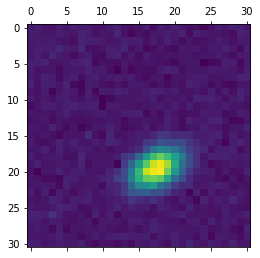

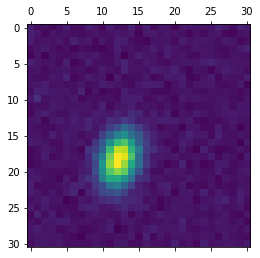

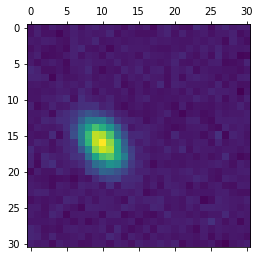

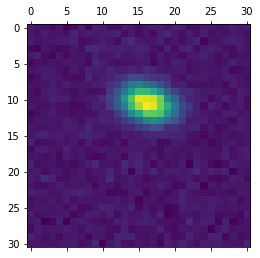

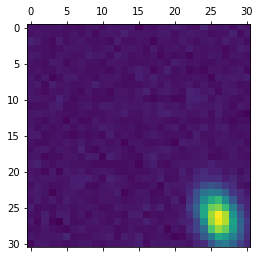

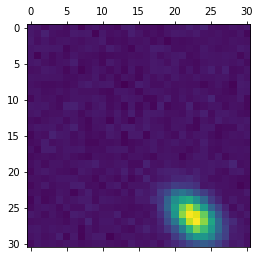

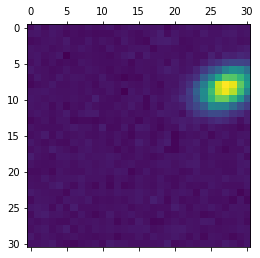

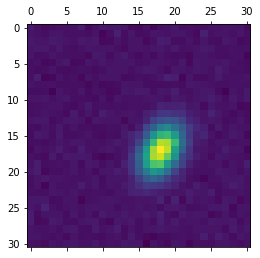

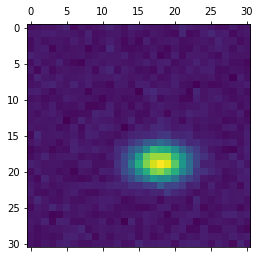

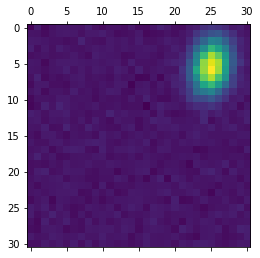

In [9]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [10]:
# The VAE
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [11]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [12]:
# torch.save(galaxy_vae.dec.state_dict(), '../galaxy_warm_starts/galaxy_dec_init.dat')

In [13]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [14]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

In [15]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [16]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [17]:
map_pixel_loc

tensor([ 382,  353,  282,  173,  528,  525,  137,  335,  360,   44])

(array([  1.,   0.,   0.,   4.,  16., 154., 326.,  15.,  10.,   4.]),
 array([4.87605600e-17, 1.59174064e-04, 3.18348128e-04, 4.77522193e-04,
        6.36696257e-04, 7.95870321e-04, 9.55044385e-04, 1.11421845e-03,
        1.27339251e-03, 1.43256658e-03, 1.59174064e-03]),
 <a list of 10 Patch objects>)

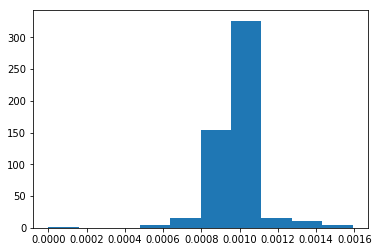

In [18]:
plt.hist(pixel_probs[0, :].detach())

In [19]:
recon_mean.sum()

tensor(3.3636e+07)

In [20]:
recon_var.sum()

tensor(3.3640e+07)

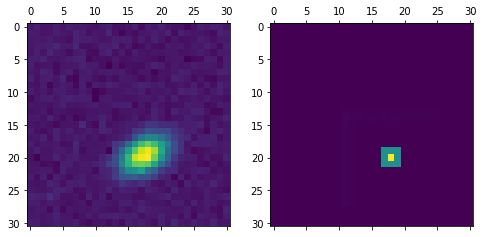

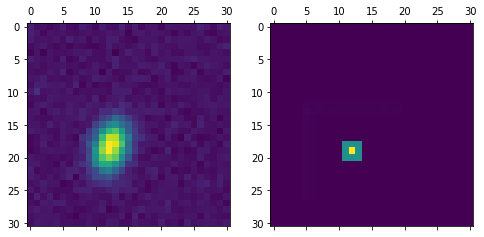

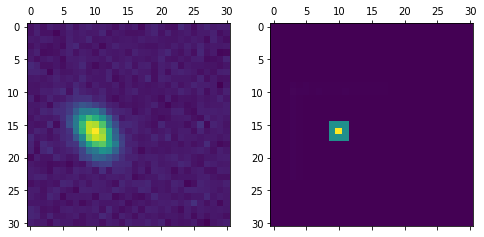

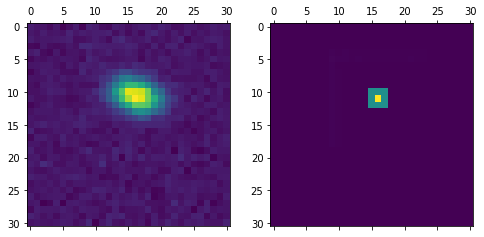

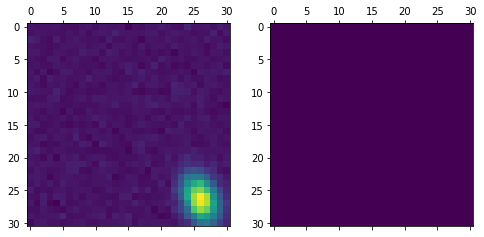

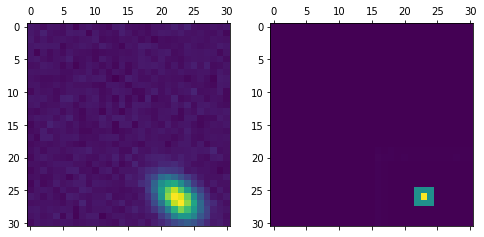

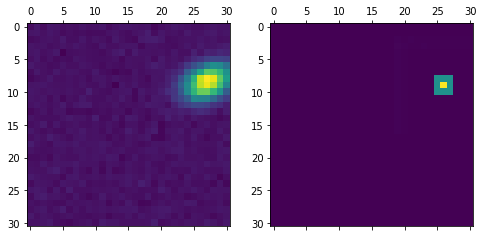

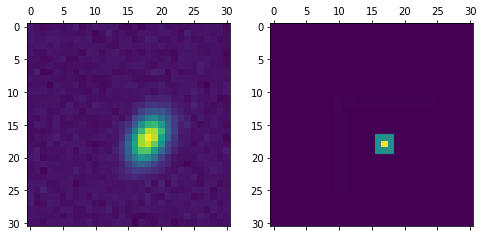

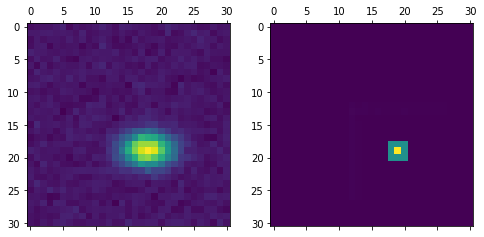

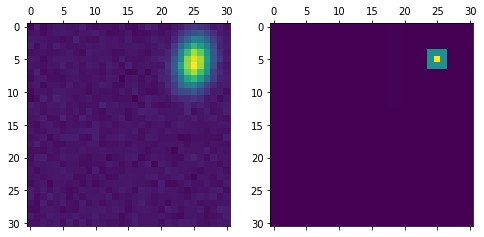

In [21]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


In [22]:
# check optimizer goes through

In [23]:
optimizer = optim.Adam(galaxy_rnn.parameters(), lr=0.001, weight_decay=1e-6)
optimizer.zero_grad()

In [24]:
pm_loss, map_loss = galaxy_rnn.get_pm_loss(images_batch1, 
                                           backgrounds_batch1, 
                                           backgrounds_batch1, 
                                           alpha = 0.0, 
                                           topk = 0, 
                                           use_baseline = True, 
                                           use_term_one_baseline = False, 
                                          n_samples = 2)

using alt. covariate
using alt. covariate


In [25]:
pm_loss

tensor(1.2471e+07)

In [26]:
map_loss

tensor(2.3012e+06)

In [27]:
pm_loss.backward()

In [28]:
optimizer.step()

In [29]:
_, map_loss2 = galaxy_rnn.get_pm_loss(images_batch1, 
                                           backgrounds_batch1, 
                                           backgrounds_batch1, 
                                           alpha = 0.0, 
                                           topk = 5, 
                                           use_baseline = True, 
                                     use_term_one_baseline = False)

using alt. covariate


In [30]:
map_loss2

tensor(2.3006e+06)

In [31]:
# Check train module

In [33]:
galaxy_lib.train_module(galaxy_rnn, train_loader, test_loader, epochs = 12, save_every = 2, 
                        alpha = 0.0, topk = 0, use_baseline = True, use_term_one_baseline = False, n_samples = 2,
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
[0] loss: 1025267  	[1.3 seconds]
  * test loss: 1213925
writing the network's parameters to ./test_epoch0.dat
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
[1] loss: 675665  	[1.2 seconds]
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
[2] loss: 388316  	[1.3 seconds]
  * test loss: 415041
writing the network's parameters to ./test_epoch2.dat
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. covariate
using alt. c

In [34]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [35]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri

In [36]:
np.load('./test_losses_array.npy')

array([4537813. , 4456150. , 1553416.1, 3825330.8, 2298799.8, 3582886. ],
      dtype=float32)